In [1]:
# for simulating from the glm, see how well the fit is, variance of estimators etc.

In [1]:
# import os
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [2]:
import jax
import jax.numpy as np
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy,pickle
from jax.tree_util import tree_map

from jax import jit,vmap
import pandas as pd
import blackjax

import sys,os,importlib,pdb
sys.path.append('/mnt/home/szheng/projects/util_code')
import gm

import scipy
from scipy.signal import find_peaks
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload

import copy

%matplotlib inline
import gm_glm_bayesian as glm

In [2]:
savefig_dir = '/mnt/home/szheng/ceph/place_variability/fig/committee1'

In [3]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
fr_map_ = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']

In [4]:
unit_int = 31
unit_str = f'unit_{unit_int}'

unit_ind_in_pyr = 0

trial_ind_dict = dict(fr.groupby('visitedArm')['trial'].unique())
fr_map_one_unit_both_trials_dict = {k:val[unit_ind_in_pyr] for k,val in fr_map_.items()}
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)

pars_rand=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


regressors=glm.get_regressors(fr)
target = fr[unit_str].values
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


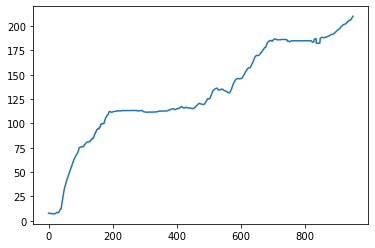

In [5]:
inds = slice(250,1200)
regressors_sim = {'trial_inds_int':regressors['trial_inds_int'][inds],'position':regressors['position'][inds],'dt':regressors['dt']}
plt.plot(regressors_sim['position'])

In [6]:
reload(gm)

<module 'gm' from '/mnt/home/szheng/projects/util_code/gm.py'>

In [7]:
def duplicate_dict(d,N=(10,1),to_exclude=['dt']):
    dd = {}
    for k,v in d.items():
        if k not in to_exclude:
            dd[k] = np.squeeze(np.tile(v,N))
        else:
            dd[k]=v
    return dd

def plot_fitted_dist(pars_fit_,true_pars=None):
    '''
    only works for one trial
    '''
    nsamples = pars_fit_['mus'].shape[0]
    mean_dict = {}
    nplots = len(pars_fit_)
    fig,axs=ph.subplots_wrapper(nplots,return_axs=True)
    if true_pars is not None:
        pars_fit = tree_map(lambda x,y:x-y,pars_fit_,true_pars)
    else:
        pars_fit=pars_fit_
        
    for ii,(k,v) in enumerate(pars_fit.items()):
        eff_v = numpy.array(v[nsamples//2:])
        mean_dict[k] = eff_v.mean(axis=0)
        for jj in range(eff_v.shape[-1]):

            axs.ravel()[ii].hist(numpy.squeeze(eff_v[...,jj]),label=jj,histtype='step',density=True)
            axs.ravel()[ii].set_title(k)
            axs.ravel()[ii].axvline(mean_dict[k][...,jj],label=jj,linestyle=':',color=f'C{jj}')
            
        
    return mean_dict,fig,axs
        
# sort fitted
def sort_pars_fit(pars_fit_gd_trial):
    sorted_field_inds = np.argsort(pars_fit_gd_trial['mus'],axis=-1)
    pars_fit_gd_trial_sorted={}
    for k in ['mus','logsigmas','logws']:
        pars_fit_gd_trial_sorted[k] = vmap(lambda x,ind:x[ind],in_axes=(0,0))(pars_fit_gd_trial[k],sorted_field_inds)
    pars_fit_gd_trial_sorted['logb']=pars_fit_gd_trial['logb']
    return pars_fit_gd_trial_sorted


In [35]:
# generate multiple trials using the same param
ntrials = 2000
# pars_sim = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=10)
pars_sim = {'logws':np.array([[60.,80.]]),'mus':np.array([[30,90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.,5.]])}
# pars_sim = duplicate_dict(pars_sim,(ntrials,1))
regressors_sim_dup=duplicate_dict(regressors_sim,N=ntrials)

target_rate = glm.forward(regressors_sim_dup,pars_sim)
target_spk = numpy.random.poisson(target_rate)



# mcmc: mala

In [9]:
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

In [10]:
%%time
regressors_ = regressors_sim_dup
nsamples = 1000000
sampler_func = blackjax.mala
# sampler_kw = {'step_size':1e-2}
sampler_kw = {'step_size':5e-3}
pars_sim_init = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=1.)
states=glm.fit(regressors_,pars_sim_init,target_spk,sampler_func=sampler_func,sampler_kw=sampler_kw,mask=None,num_samples=nsamples,rng_key_int=0)
pars_fit = states.position


CPU times: user 2min 8s, sys: 34.5 ms, total: 2min 8s
Wall time: 2min 9s


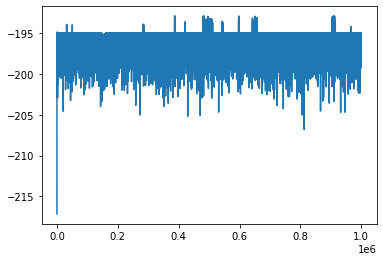

In [11]:
plt.plot(states.logprob)

In [12]:
tree_map(lambda x:x[-1],pars_sim)

{'logb': DeviceArray(1., dtype=float32),
 'logsigmas': DeviceArray([5., 5.], dtype=float32),
 'logws': DeviceArray([60., 80.], dtype=float32),
 'mus': DeviceArray([30, 90], dtype=int32)}

In [13]:
pars_fit_final=tree_map(lambda x:x[-1],pars_fit)
pars_fit_final

{'logb': DeviceArray([1.1097122], dtype=float32),
 'logsigmas': DeviceArray([[ 35.860928, -13.18193 ]], dtype=float32),
 'logws': DeviceArray([[-221.57469,  221.75745]], dtype=float32),
 'mus': DeviceArray([[73.56619, 90.00692]], dtype=float32)}

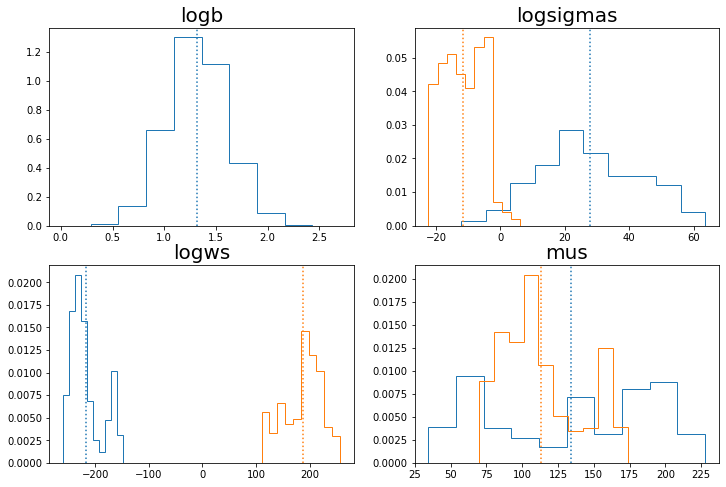

In [14]:
mean_dict,fig,axs=plot_fitted_dist(pars_fit)

In [24]:
mean_dict

{'logb': array([0.9668669], dtype=float32),
 'logsigmas': array([[7.418334 , 5.1761584]], dtype=float32),
 'logws': array([[57.669353, 74.964645]], dtype=float32),
 'mus': array([[30.559723, 90.55547 ]], dtype=float32)}

In [11]:
print(glm.logpdf_no_reg(regressors_,pars_sim,target_spk,mask=None,noise_type="poisson"))
print('fitted',glm.logpdf_no_reg(regressors_,mean_dict,target_spk,mask=None,noise_type="poisson"))

-1879.8081


NameError: name 'mean_dict' is not defined

In [16]:
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

# if only use gd

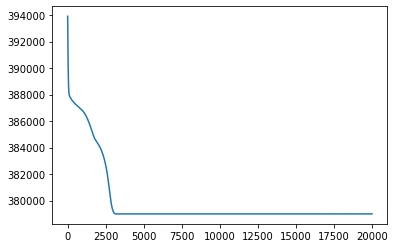

In [36]:
# if only use gd
pars_sim_init = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=1.)
niters=20000
lr=1e-2
regressors_ = regressors_sim_dup
pars_fit_gd,loss_l=gm.train_adam(glm.negative_logpdf_no_reg,regressors_,pars_sim_init,target_spk,reg_pars=None,loss_type='poisson',niters=niters,lr=lr)

plt.plot(loss_l)

In [37]:
pars_sim

{'logws': DeviceArray([[60., 80.]], dtype=float32),
 'mus': DeviceArray([[30, 90]], dtype=int32),
 'logb': DeviceArray([1.], dtype=float32),
 'logsigmas': DeviceArray([[5., 5.]], dtype=float32)}

In [38]:
pars_fit_gd

{'logb': DeviceArray([1.0126476], dtype=float32),
 'logsigmas': DeviceArray([[4.9826427, 4.7182245]], dtype=float32),
 'logws': DeviceArray([[78.45282 , 57.475502]], dtype=float32),
 'mus': DeviceArray([[90.05269 , 30.354206]], dtype=float32)}

In [39]:
print(glm.logpdf_no_reg(regressors_,pars_sim,target_spk,mask=None,noise_type="poisson"))
print('fitted',glm.logpdf_no_reg(regressors_,pars_fit_gd,target_spk,mask=None,noise_type="poisson"))

-379005.06
fitted -378997.5


In [40]:
ntrials

2000

In [12]:
pars_fit_gd_trial_average=copy.copy(pars_fit_gd)

# fitting per trial

CPU times: user 16min 40s, sys: 256 ms, total: 16min 40s
Wall time: 16min 42s


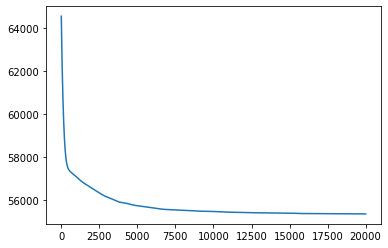

In [14]:
%%time
pars_sim_init = gm.init_all_trials(ntrials=ntrials,random_init=True,sigma_default=1.)
niters=20000
lr=1e-2
regressors_=copy.copy(regressors_sim_dup)
ntime_in_trial=len(range(inds.start,inds.stop))
regressors_['trial_inds_int']=np.repeat(np.arange(ntrials),ntime_in_trial)

pars_fit_gd_trial,loss_l=gm.train_adam(glm.negative_logpdf_no_reg,regressors_,pars_sim_init,target_spk,reg_pars=None,loss_type='poisson',niters=niters,lr=lr)

plt.plot(loss_l)


In [15]:
print(glm.logpdf_no_reg(regressors_sim_dup,pars_sim,target_spk,mask=None,noise_type="poisson"))
print('fitted',glm.logpdf_no_reg(regressors_,pars_fit_gd_trial,target_spk,mask=None,noise_type="poisson"))

-56444.688
fitted -55367.39


In [16]:
pars_fit_gd_trial_sorted = sort_pars_fit(pars_fit_gd_trial)
    
pars_fit_gd_trial_sorted=tree_map(lambda x:np.expand_dims(x,1), pars_fit_gd_trial_sorted
                                 )

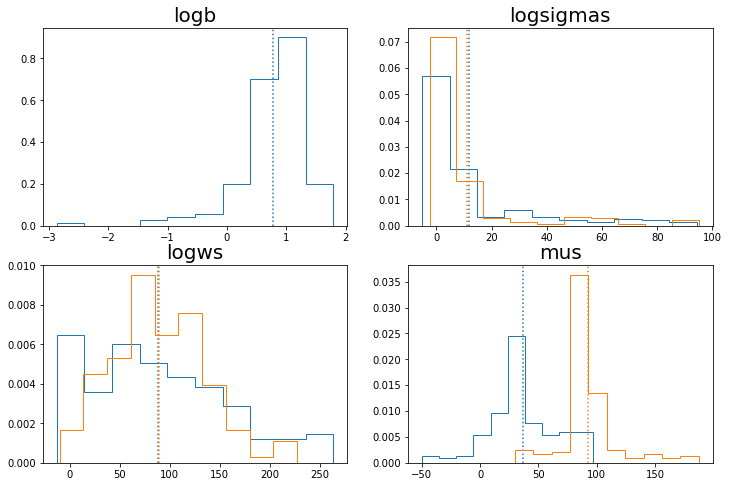

In [17]:
mean_dict,fig,axs=plot_fitted_dist(pars_fit_gd_trial_sorted)

In [18]:
pars_sim

{'logws': DeviceArray([[60., 80.]], dtype=float32),
 'mus': DeviceArray([[30, 90]], dtype=int32),
 'logb': DeviceArray([1.], dtype=float32),
 'logsigmas': DeviceArray([[5., 5.]], dtype=float32)}

In [20]:
mean_dict

{'logb': array([0.78183645], dtype=float32),
 'logsigmas': array([[11.944528, 10.964977]], dtype=float32),
 'logws': array([[88.4794 , 88.95658]], dtype=float32),
 'mus': array([[36.489536, 92.619026]], dtype=float32)}

# vmap fits

In [ ]:
# for each run, either ntrials=1, or ntrials=ntrials 

In [32]:
def gen_spk_fit(target_rate,regressors_,key,ntrials,ninittrials=1,niters=20000,lr=1e-2):
    '''
    ninittrials: should be 1 both for trial average or single trial multi run; not 1 only when multi run using smoothness
    '''
    target_spk = jax.random.poisson(key,target_rate)
    pars_sim_init = gm.init_all_trials(ntrials=ninittrials,random_init=True,sigma_default=1.) 

    regressors_=copy.copy(regressors_sim_dup)
    ntime_in_trial=len(range(inds.start,inds.stop))
    regressors_['trial_inds_int']=np.repeat(np.arange(ntrials),ntime_in_trial)

    pars_fit_gd_trial,loss_l=gm.train_adam(glm.negative_logpdf_no_reg,regressors_,pars_sim_init,target_spk,reg_pars=None,loss_type='poisson',niters=niters,lr=lr)
        
    pars_sorted=sort_pars_fit(pars_fit_gd_trial)
    
    return pars_sorted,loss_l

gen_spk_fit_runs = vmap(gen_spk_fit,in_axes=(0,None,0,None))


## one trial, multiple runs

In [65]:
ntrials = 1
# pars_sim = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=10)
pars_sim = {'logws':np.array([[60.,80.]]),'mus':np.array([[30,90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.,5.]])}
# pars_sim = duplicate_dict(pars_sim,(ntrials,1))
regressors_sim_dup=duplicate_dict(regressors_sim,N=ntrials)

target_rate = glm.forward(regressors_sim_dup,pars_sim)




In [74]:
%%time
nruns = 100
target_rate_runs = np.tile(target_rate,(nruns,1))
key=jax.random.PRNGKey(0)
key_runs = jax.random.split(key,num=nruns)
pars_sorted_runs,loss_l_runs = gen_spk_fit_runs(target_rate_runs,regressors_,key_runs,ntrials,ninittrials=1)


CPU times: user 1min 21s, sys: 132 ms, total: 1min 21s
Wall time: 1min 22s


In [61]:
pars_sorted_runs_50 = copy.copy(pars_sorted_runs)

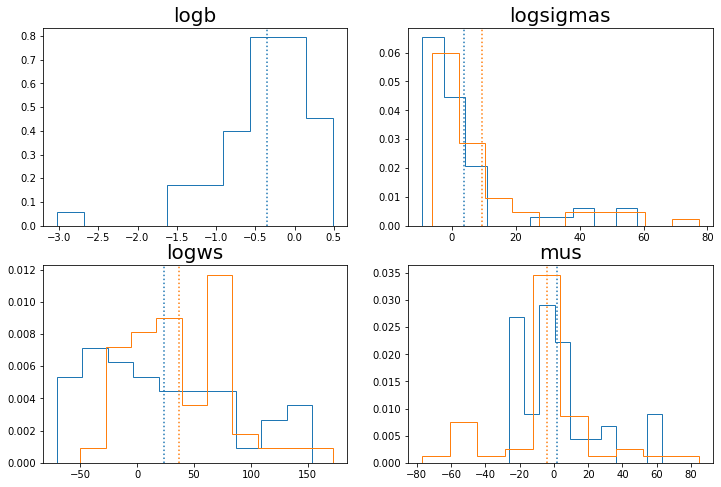

In [83]:
# mean_dict,fig,axs=plot_fitted_dist(pars_sorted_runs)
mean_dict,fig,axs = plot_fitted_dist(pars_sorted_runs,true_pars=pars_sim)

In [84]:
fig.savefig(os.path.join(savefig_dir,f'pars_nruns{nruns}_ntrials{ntrials}_gd_centered.pdf'))

In [76]:
mean_dict

{'logb': array([0.6467824], dtype=float32),
 'logsigmas': array([[ 8.7050705, 14.52796  ]], dtype=float32),
 'logws': array([[ 83.31248, 116.58581]], dtype=float32),
 'mus': array([[31.73606, 85.90785]], dtype=float32)}

## multi trials averaged, multi runs

In [71]:
ntrials = 30
# pars_sim = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=10)
pars_sim = {'logws':np.array([[60.,80.]]),'mus':np.array([[30,90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.,5.]])}
# pars_sim = duplicate_dict(pars_sim,(ntrials,1))
regressors_sim_dup=duplicate_dict(regressors_sim,N=ntrials)

target_rate = glm.forward(regressors_sim_dup,pars_sim)




In [72]:
%%time
key=jax.random.PRNGKey(1)
pars_sorted,loss_l=gen_spk_fit(target_rate,regressors_,key,ntrials,lr=1e-3,niters=30000)

CPU times: user 40.2 s, sys: 34.5 ms, total: 40.3 s
Wall time: 40.3 s


In [73]:
pars_sorted

{'mus': DeviceArray([[29.117107, 90.79477 ]], dtype=float32),
 'logsigmas': DeviceArray([[3.0127568, 3.5345688]], dtype=float32),
 'logws': DeviceArray([[82.779015, 65.644356]], dtype=float32),
 'logb': DeviceArray([1.0164521], dtype=float32)}

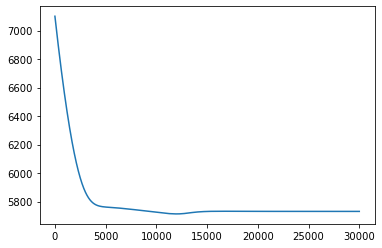

In [74]:
plt.plot(loss_l)

In [77]:
%%time
nruns = 30
regressors_ = regressors_sim_dup
target_rate_runs = np.tile(target_rate,(nruns,1))
key=jax.random.PRNGKey(0)
key_runs = jax.random.split(key,num=nruns)
gen_spk_fit_runs = vmap(lambda target_rate,regressors_,key:gen_spk_fit(target_rate,regressors_,key,ntrials,lr=1e-3,niters=20000),in_axes=(0,None,0))
pars_sorted_runs,loss_l_runs = gen_spk_fit_runs(target_rate_runs,regressors_,key_runs)


CPU times: user 8min 12s, sys: 216 ms, total: 8min 12s
Wall time: 8min 13s


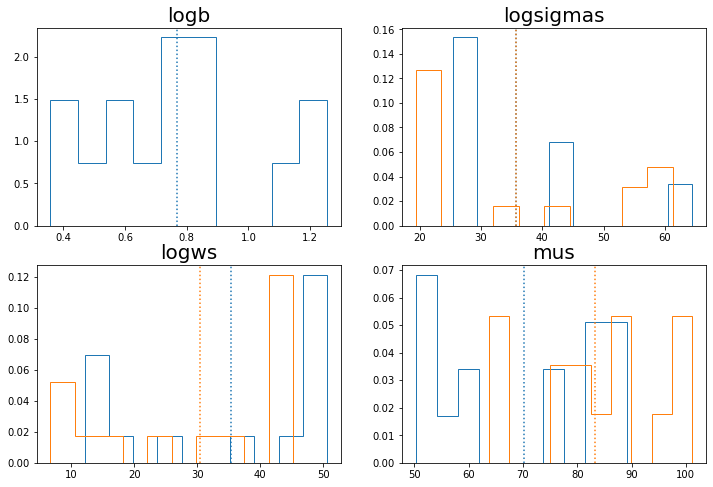

In [78]:
mean_dict,fig,axs = plot_fitted_dist(pars_sorted_runs,true_pars=None)
# mean_dict,fig,axs = plot_fitted_dist(pars_sorted_runs,true_pars=pars_sim)

In [79]:
mean_dict

{'logb': array([0.7699835], dtype=float32),
 'logsigmas': array([[35.664566, 35.708397]], dtype=float32),
 'logws': array([[35.316265, 30.429705]], dtype=float32),
 'mus': array([[70.11623 , 83.338356]], dtype=float32)}

# fitting per trial plus reg

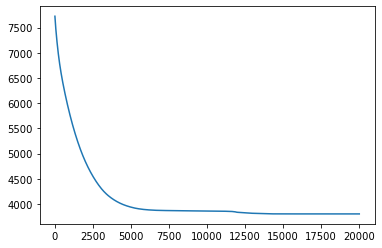

In [34]:
reload(glm)
pars_sim_init = gm.init_all_trials(ntrials=ntrials,random_init=True,sigma_default=1.)
niters=20000
lr=1e-2
regressors_=copy.copy(regressors_sim_dup)
ntime_in_trial=len(range(inds.start,inds.stop))
regressors_['trial_inds_int']=np.repeat(np.arange(ntrials),ntime_in_trial)
reg_pars = gm.get_reg_pars(reg_pars_={'g_mu':1,'g_sigmas':1,'g_w':1,'g_b':1,'nfields':2})
pars_fit_gd_trial,loss_l=gm.train_adam(glm.negative_logpdf,regressors_,pars_sim_init,target_spk,reg_pars=reg_pars,reg_type='quad_variation',loss_type='poisson',niters=niters,lr=lr)

plt.plot(loss_l)


In [32]:
pars_sim

{'logws': DeviceArray([[60., 80.]], dtype=float32),
 'mus': DeviceArray([[30, 90]], dtype=int32),
 'logb': DeviceArray([1.], dtype=float32),
 'logsigmas': DeviceArray([[5., 5.]], dtype=float32)}

{'logb': array([0.87265664], dtype=float32),
 'logsigmas': array([[48.922897, 12.02485 ]], dtype=float32),
 'logws': array([[77.518456, 82.291   ]], dtype=float32),
 'mus': array([[32.479866, 91.44925 ]], dtype=float32)}

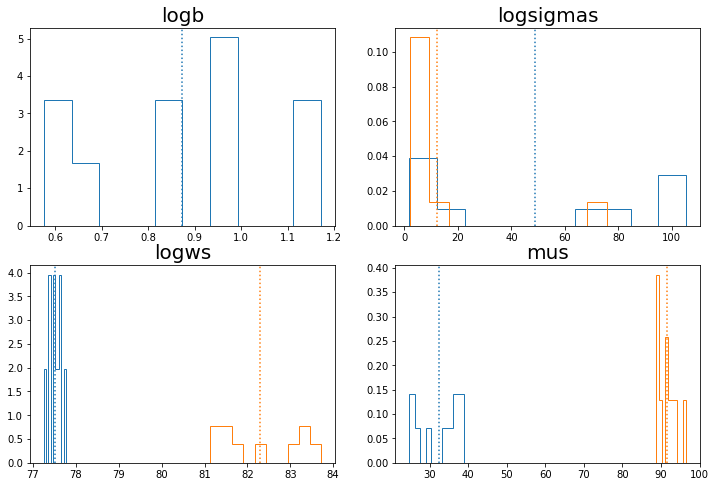

In [35]:
# sort fitted
sorted_field_inds = np.argsort(pars_fit_gd_trial['mus'],axis=-1)
pars_fit_gd_trial_sorted={}
for k in ['mus','logsigmas','logws']:
    pars_fit_gd_trial_sorted[k] = vmap(lambda x,ind:x[ind],in_axes=(0,0))(pars_fit_gd_trial[k],sorted_field_inds)
pars_fit_gd_trial_sorted['logb']=pars_fit_gd_trial['logb']
    
pars_fit_gd_trial_sorted=tree_map(lambda x:np.expand_dims(x,1), pars_fit_gd_trial_sorted
                                 )
mean_dict,fig,axs=plot_fitted_dist(pars_fit_gd_trial_sorted)
mean_dict

# other

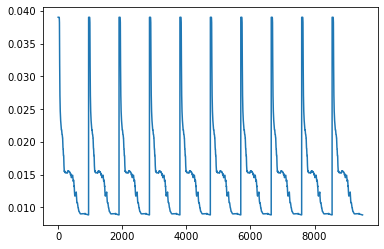

In [59]:
plt.plot(target_rate)

<AxesSubplot:xlabel='position_bin'>

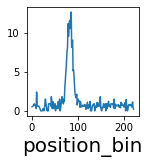

In [5]:
regressors_sim_df = {'trial_inds_int':regressors_sim['trial_inds_int'],'position':regressors_sim['position']}

regressors_sim_df = pd.DataFrame(regressors_sim_df)

regressors_sim_df['target_spk'] = target_spk

posbin = pd.cut(regressors_sim_df['position'],bins=221,retbins=True,labels=False)[0]
regressors_sim_df['position_bin']=posbin

(regressors_sim_df.groupby('position_bin')['target_spk'].mean()/0.033).plot(figsize=(2,2))

<AxesSubplot:xlabel='position_bin'>

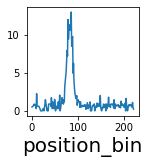

In [6]:
(regressors_sim_df.groupby('position_bin')['target_spk'].var()/0.033).plot(figsize=(2,2))

In [7]:
regressors_sim_df['trial_inds_int_individual'] = numpy.arange(nrep).repeat(inds.sum())

In [8]:
def getcom(df):
    gpb=df.groupby('position_bin')
    map_hat=gpb['target_spk'].mean()
    muhat=numpy.sum(map_hat*map_hat.index)/map_hat.sum()
    return muhat

In [170]:
regressors_sim_df.groupby('trial_inds_int_individual').apply(getcom).agg(mean='mean',var='var',std='std')



mean    106.217592
var     122.931197
std      11.087434
dtype: float64

<AxesSubplot:>

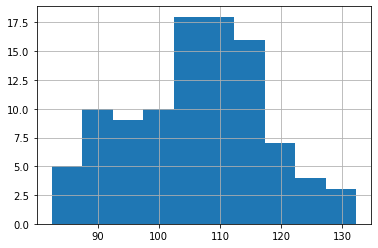

In [145]:
regressors_sim_df.groupby('trial_inds_int_individual').apply(getcom).hist()

{'trial_inds_int': array([0, 0, 0, ..., 0, 0, 0]),
 'position': array([  3.1310937 ,   3.1310937 , 218.72816   , ...,   0.9840581 ,
          0.89459825,   0.7156786 ], dtype=float32),
 'dt': 0.033333333333757764}

In [176]:
nrep

100

In [180]:
%%time
nsamples = 10000
sampler_func = blackjax.mala
sampler_kw = {'step_size':1e-3}
regressors_=copy.copy(regressors_sim)
regressors_['trial_inds_int'] = numpy.arange(nrep).repeat(inds.sum())

pars_sim_init = {'logws':numpy.random.rand(nrep,1)*100+100,'mus':numpy.random.rand(nrep,1)*100+15,'logsigmas':numpy.random.rand(nrep,1)*3+5,'logb':numpy.array([0.]*nrep)}
states=glm.fit(regressors_,pars_sim_init,target_spk,sampler_func=sampler_func,sampler_kw=sampler_kw,mask=None,num_samples=nsamples,rng_key_int=0)


CPU times: user 54.9 s, sys: 19.8 ms, total: 55 s
Wall time: 54.9 s


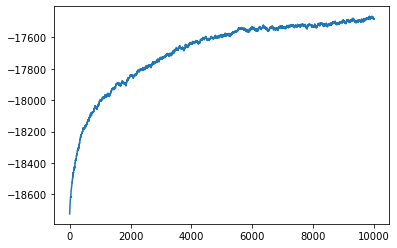

In [181]:
plt.plot(states.logprob)

(array([ 7., 13., 10.,  8.,  8.,  8.,  4.,  9., 29.,  4.]),
 array([ 17.215666,  26.33768 ,  35.459698,  44.58171 ,  53.703728,
         62.825745,  71.94776 ,  81.06978 ,  90.19179 ,  99.313805,
        108.43582 ], dtype=float32),
 <BarContainer object of 10 artists>)

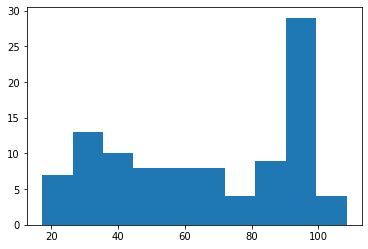

In [186]:
xx=numpy.array(states.position['mus'][nsamples//2:].mean(axis=0))
plt.hist(xx)

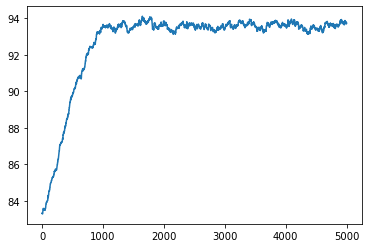

In [174]:
plt.plot(np.squeeze(states.position['mus']))

(array([ 191.,  770., 1034.,  417.,   88.]),
 array([93.164734, 93.37069 , 93.576645, 93.78261 , 93.98856 , 94.19452 ],
       dtype=float32),
 [<matplotlib.patches.Polygon at 0x1553d7576760>])

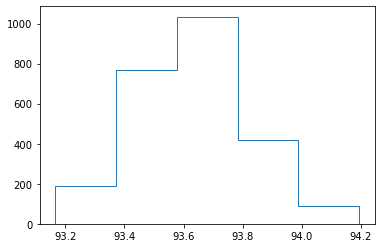

In [164]:
aa=np.squeeze(states.position['mus'][nsamples//2:])
aa=numpy.array(aa)
plt.hist(aa,bins=5,histtype='step')

In [165]:
pars_sim

{'logws': array([[181.74035029]]),
 'mus': array([[93.45210059]]),
 'logsigmas': array([[5.79489241]]),
 'logb': array([0.])}